In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import numpy as np
import scipy.io
import torch.nn.init
from scipy.stats import qmc 
import matplotlib.pyplot as plt
from matplotlib import cm 

device = torch.device("cuda:0" if torch.cuda.is_available() else"cpu")
print(device)

cuda:0


In [2]:
data =  scipy.io.loadmat('../../data/cylinder_nektar_wake.mat')
N_train = 5000

X_star=data['X_star'] #Nx2
t_star=data['t'] #Tx1
P_star=data['p_star'] #NxT
U_star=data['U_star'] #Nx2xT

N=X_star.shape[0]
T=t_star.shape[0]

XX = np.tile(X_star[:,0:1], (1,T)) #N x T
YY = np.tile(X_star[:, 1:2], (1,T)) #N x T
TT = np.tile(t_star,(1,N)).T #N x T

UU = U_star[:,0,:] 
VV = U_star[:,1,:]
PP = P_star

x = XX.flatten()[:,None] # NT x 1 (x 좌표)
y = YY.flatten()[:,None] # NT x 1 (y 좌표)
t = TT.flatten()[:,None] # NT x 1 (시간)

u = UU.flatten()[:,None] # NT x 1 (x 방향 속도)
v = VV.flatten()[:,None] # NT x 1 (y 방향 속도)
p = PP.flatten()[:,None] # NT x 1 (압력)

idx = np.random.choice(N*T, N_train, replace=False)
x_train = x[idx,:]
y_train = y[idx,:]
t_train = t[idx,:]
u_train = u[idx,:]
v_train = v[idx,:]



In [3]:

class Net(nn.Module) :
    def __init__(self, layerlist, actftn=torch.tanh, initializer=nn.init.xavier_uniform_) :
        super(Net,self).__init__()
        self.actftn = actftn
        self.layers = nn.ModuleList()

        for i in range(len(layerlist)-1):
            self.layers.append(nn.Linear(layerlist[i],layerlist[i+1]))

        self.lambda1 = nn.Parameter(torch.tensor(0.0))
        self.lambda2 = nn.Parameter(torch.tensor(0.0))

    def forward(self,x,y,t) :
        inputs = torch.cat([x,y,t],axis =1 )
        out = inputs
        for layer in self.layers[:-1]:
            out = self.actftn(layer(out))

        output =self.layers[-1](out) 
        return output

In [4]:
net = Net([3,64,64,64,64,64,2],torch.tanh,nn.init.xavier_uniform_) # is what we defined and stands for net.
net = net.to(device) #is to send net calculation to device
mse_cos_function = torch.nn.MSELoss() #is mean squared error loss function
optimizer = torch.optim.Adam(net.parameters())

In [5]:
def fg(x,y,t,lamb, net):
    output = net(x,y,t)  # h: (batch_size, 2)
    psi = output[:, 0:1]  # (batch_size, 1)
    p = output[:, 1:2]  # (batch_size, 1)
    lambda1 = net.lambda1
    lambda2 = net.lambda2
    
    u = torch.autograd.grad(psi.sum(), y, create_graph=True)[0]
    v = -torch.autograd.grad(psi.sum(), x, create_graph=True)[0]
    u_x = torch.autograd.grad(u.sum(), x, create_graph=True)[0]
    u_y = torch.autograd.grad(u.sum(), y, create_graph=True)[0]
    v_t = torch.autograd.grad(v.sum(), t, create_graph=True)[0]
    v_x = torch.autograd.grad(v.sum(), x, create_graph=True)[0]
    v_y = torch.autograd.grad(v.sum(), y, create_graph=True)[0]
    u_t = torch.autograd.grad(u.sum(), t, create_graph=True)[0]
    v_xx = torch.autograd.grad(v_x.sum(), x, create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x.sum(), x, create_graph=True)[0]
    v_yy = torch.autograd.grad(v_y.sum(), y, create_graph=True)[0]
    u_yy = torch.autograd.grad(u_y.sum(), y, create_graph=True)[0]
    p_x = torch.autograd.grad(p.sum(), x, create_graph=True)[0]
    p_y = torch.autograd.grad(p.sum(), y, create_graph=True)[0]

    # 거듭제곱은 ** 연산자로!
    f = u_t + lambda1*(u*u_x+v*u_y) +p_x+ -lambda2*(u_xx + u_yy)
    g = v_t + lambda1*(u*v_x+v*v_y) +p_y+ -lambda2*(v_xx + v_yy)
    # np.append 대신 torch.cat을 사용해 (batch_size, 2) 텐서로 합친다
    residual = torch.cat([f, g], dim=1)

    return residual, u ,v, p


In [6]:
losses = []
iterations = 20000
previous_validation_loss=99999999.0
    #loss based on bc
lamb=np.array([0,0])    
pt_lamb = Variable(torch.from_numpy(lamb).float(),requires_grad=True).to(device) 
pt_x = Variable(torch.from_numpy(x_train).float(),requires_grad=True).to(device)
pt_y= Variable(torch.from_numpy(y_train).float(),requires_grad=True).to(device) 
pt_t = Variable(torch.from_numpy(t_train).float(),requires_grad=True).to(device)
pt_u = Variable(torch.from_numpy(u_train).float(),requires_grad=False).to(device)
pt_v = Variable(torch.from_numpy(v_train).float(),requires_grad=False).to(device)
    
for epoch in range(iterations) :
    optimizer.zero_grad()
    all_zeros = np.zeros((N_train,1))
    pt_all_zeros = Variable(torch.from_numpy(all_zeros).float(), requires_grad=False).to(device)
    

    res,u_pred,v_pred,p_pred = fg(pt_x,pt_y,pt_t,pt_lamb,net)
    mse_u = mse_cos_function(u_pred,pt_u)
    mse_v = mse_cos_function(v_pred,pt_v)
    mse_data = (mse_u +mse_v )/2

    
    #loss based on PDE
    
 

    mse_res = mse_cos_function(res,pt_all_zeros)
    
    loss =mse_data +  mse_res
    
    loss.backward()
    
    optimizer.step()
    
    with torch.autograd.no_grad():
        print(epoch, "training loss", loss.data)
        print("Lambda values:", net.lambda1.item(), net.lambda2.item())
        loss_value = loss.item()
        losses.append(loss_value)
    torch.save(net.state_dict(), "parameters_checkpoints/Model_parameters.pth")


c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([5000, 1])) that is different to the input size (torch.Size([5000, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


0 training loss tensor(0.4524, device='cuda:0')
Lambda values: -0.0005241680191829801 0.0009899145225062966
1 training loss tensor(0.4458, device='cuda:0')
Lambda values: -0.000116752453322988 0.001979836728423834
2 training loss tensor(0.4393, device='cuda:0')
Lambda values: 0.0005394924082793295 0.0029281636234372854
3 training loss tensor(0.4320, device='cuda:0')
Lambda values: 0.0012397392420098186 0.003808459034189582
4 training loss tensor(0.4236, device='cuda:0')
Lambda values: 0.0019522467628121376 0.004648882430046797
5 training loss tensor(0.4135, device='cuda:0')
Lambda values: 0.0026710969395935535 0.005470022559165955
6 training loss tensor(0.4014, device='cuda:0')
Lambda values: 0.003395297797396779 0.0062833609990775585
7 training loss tensor(0.3871, device='cuda:0')
Lambda values: 0.004125542473047972 0.0070959534496068954
8 training loss tensor(0.3702, device='cuda:0')
Lambda values: 0.004863210488110781 0.00791266281157732
9 training loss tensor(0.3508, device='cuda:0

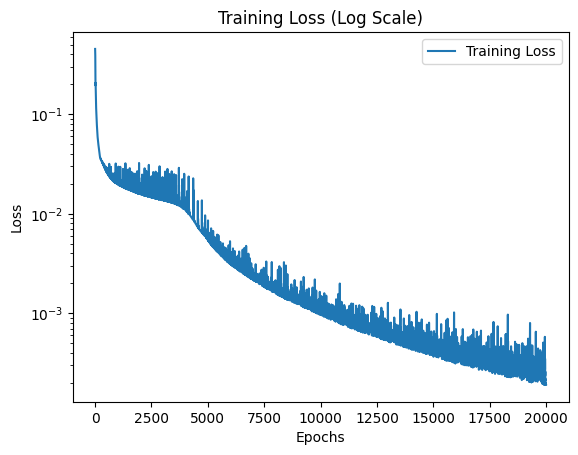

In [10]:

plt.plot(losses, label="Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.yscale("log")
plt.legend()
plt.title("Training Loss (Log Scale)")
plt.show()


t value at index 0: 0.0


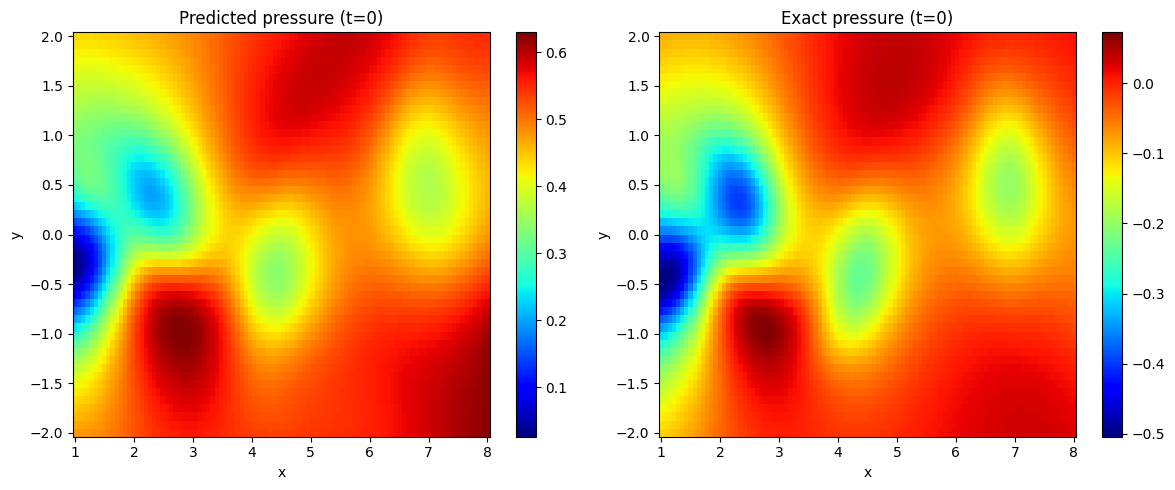

In [8]:

# Load the data
data = scipy.io.loadmat('../../data/cylinder_nektar_wake.mat')
X_star = data['X_star']  # Nx2
t_star = data['t']  # Tx1
P_star = data['p_star']  # NxT

# Find the index where t=0 (or closest to 0)
t0_idx = np.argmin(np.abs(t_star))
print(f"t value at index {t0_idx}: {t_star[t0_idx][0]}")

# Extract the exact pressure at t=0
p_exact_t0 = P_star[:, t0_idx]

# Create a meshgrid for visualization
N = X_star.shape[0]
x = X_star[:, 0]
y = X_star[:, 1]

# Assuming the model is already trained and 'net' is defined
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Function to predict pressure using the trained model
def predict_pressure(x_points, y_points, t_value, model):
    x_tensor = torch.tensor(x_points.reshape(-1, 1), dtype=torch.float32).to(device)
    y_tensor = torch.tensor(y_points.reshape(-1, 1), dtype=torch.float32).to(device)
    t_tensor = torch.tensor(np.ones_like(x_points.reshape(-1, 1)) * t_value, dtype=torch.float32).to(device)
    
    with torch.no_grad():
        outputs = model(x_tensor, y_tensor, t_tensor)
        # Assuming the second output is pressure, as in your fg function
        p_pred = outputs[:, 1:2].cpu().numpy()
    
    return p_pred.reshape(x_points.shape)

# Get the predicted pressure at t=0
# Note: This assumes your net is already trained. If not, you'd need to train it first.
t0_value = t_star[t0_idx][0]
p_pred_t0 = predict_pressure(x, y, t0_value, net)

# Create a mesh grid for better visualization
# We need to reshape the data into a 2D grid
# First, determine unique x and y coordinates
unique_x = np.unique(x)
unique_y = np.unique(y)
X_grid, Y_grid = np.meshgrid(unique_x, unique_y)

# Initialize grids for predicted and exact pressure
P_pred_grid = np.zeros_like(X_grid)
P_exact_grid = np.zeros_like(X_grid)

# For each point in our data, find its position in the grid
for i in range(N):
    x_idx = np.where(unique_x == x[i])[0][0]
    y_idx = np.where(unique_y == y[i])[0][0]
    P_pred_grid[y_idx, x_idx] = p_pred_t0[i]
    P_exact_grid[y_idx, x_idx] = p_exact_t0[i]

# Plot both the predicted and exact pressure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot predicted pressure
im1 = ax1.pcolormesh(X_grid, Y_grid, P_pred_grid, cmap='jet', shading='auto')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_title('Predicted pressure (t=0)')
fig.colorbar(im1, ax=ax1)

# Plot exact pressure
im2 = ax2.pcolormesh(X_grid, Y_grid, P_exact_grid, cmap='jet', shading='auto')
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_title('Exact pressure (t=0)')
fig.colorbar(im2, ax=ax2)

plt.tight_layout()
plt.savefig('figures/pressure_comparison_t0.png', dpi=300, bbox_inches='tight')
plt.show()